# Stock data forecasting



Crawl Apple stock price from Yahoo finance.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [45]:
import os
import pandas as pd
import yfinance as yf
from datetime import datetime

def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch historical stock data for a given ticker and date range.

    Args:
        ticker (str): Stock ticker symbol
        start_date (str): Start date in format 'YYYY-MM-DD'
        end_date (str): End date in format 'YYYY-MM-DD'

    Returns:
        DataFrame: Stock price data
    """
    print(f"Fetching data for {ticker} from {start_date} to {end_date}")

    try:
        # Use yfinance to download the data
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date)

        # Process the DataFrame
        if not df.empty:
            # Reset the index to make Date a column
            df = df.reset_index()

            # Add ticker column
            df['Ticker'] = ticker

            # Format the Date column
            df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

            return df
        else:
            print(f"No data retrieved for {ticker}")
            return None

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

def save_to_csv(df, ticker, output_dir=None):
    """
    Save stock data to a CSV file in the specified directory.

    Args:
        df (DataFrame): Stock data to save
        ticker (str): Stock ticker symbol
        output_dir (str, optional): Directory to save the file

    Returns:
        str: Path to the saved file
    """
    if df is None or df.empty:
        print(f"No data to save for {ticker}")
        return None

    # Set default output directory if not specified
    if output_dir is None:
        # Use the data directory in the project
        #script_dir = os.path.dirname(os.path.abspath(__file__))
        #project_root = os.path.dirname(script_dir)
        output_dir = os.path.join('data', 'stock_prices')

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Create a filename with the ticker and current date
    current_date = datetime.now().strftime('%Y%m%d')
    filename = f"{ticker}_data_{current_date}.csv"
    file_path = os.path.join(output_dir, filename)

    # Save the DataFrame to CSV
    df.to_csv(file_path, index=False)
    print(f"Saved data for {ticker} to {file_path}")

    return file_path

def get_stock_data(ticker, start_date, end_date, save=True, output_dir=None):
    """
    Fetch and optionally save stock data for a given ticker and date range.

    Args:
        ticker (str): Stock ticker symbol
        start_date (str): Start date in format 'YYYY-MM-DD'
        end_date (str): End date in format 'YYYY-MM-DD'
        save (bool, optional): Whether to save the data to CSV
        output_dir (str, optional): Directory to save the file

    Returns:
        tuple: (DataFrame with stock data, Path to saved file if save=True)
    """
    # Fetch the data
    df = fetch_stock_data(ticker, start_date, end_date)

    # Save the data if requested
    file_path = None
    if save and df is not None:
        file_path = save_to_csv(df, ticker, output_dir)

    return df, file_path

# Example data
ticker = "AAPL"
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = "2020-01-01"

# Fetch and save data
data, file_path = get_stock_data(ticker, start_date, end_date, output_dir="data/stock_prices")

# Print summary
if data is not None:
    print(f"\nRetrieved {len(data)} days of data for {ticker}")
    print(f"Date range: {data['Date'].min()} to {data['Date'].max()}")
    print(f"Data saved to: {file_path}")

data.head()

Fetching data for AAPL from 2020-01-01 to 2025-04-09
Saved data for AAPL to data/stock_prices/AAPL_data_20250409.csv

Retrieved 1324 days of data for AAPL
Date range: 2020-01-02 to 2025-04-08
Data saved to: data/stock_prices/AAPL_data_20250409.csv


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2020-01-02,71.721019,72.776598,71.466812,72.716072,135480400,0.0,0.0,AAPL
1,2020-01-03,71.941313,72.771729,71.783947,72.009102,146322800,0.0,0.0,AAPL
2,2020-01-06,71.127873,72.621654,70.876083,72.582916,118387200,0.0,0.0,AAPL
3,2020-01-07,72.592594,72.849224,72.021231,72.241547,108872000,0.0,0.0,AAPL
4,2020-01-08,71.943766,73.706287,71.943766,73.403656,132079200,0.0,0.0,AAPL


## Data preprocessing and visualization

Process data.

Training data: 1059 rows
Test data: 265 rows


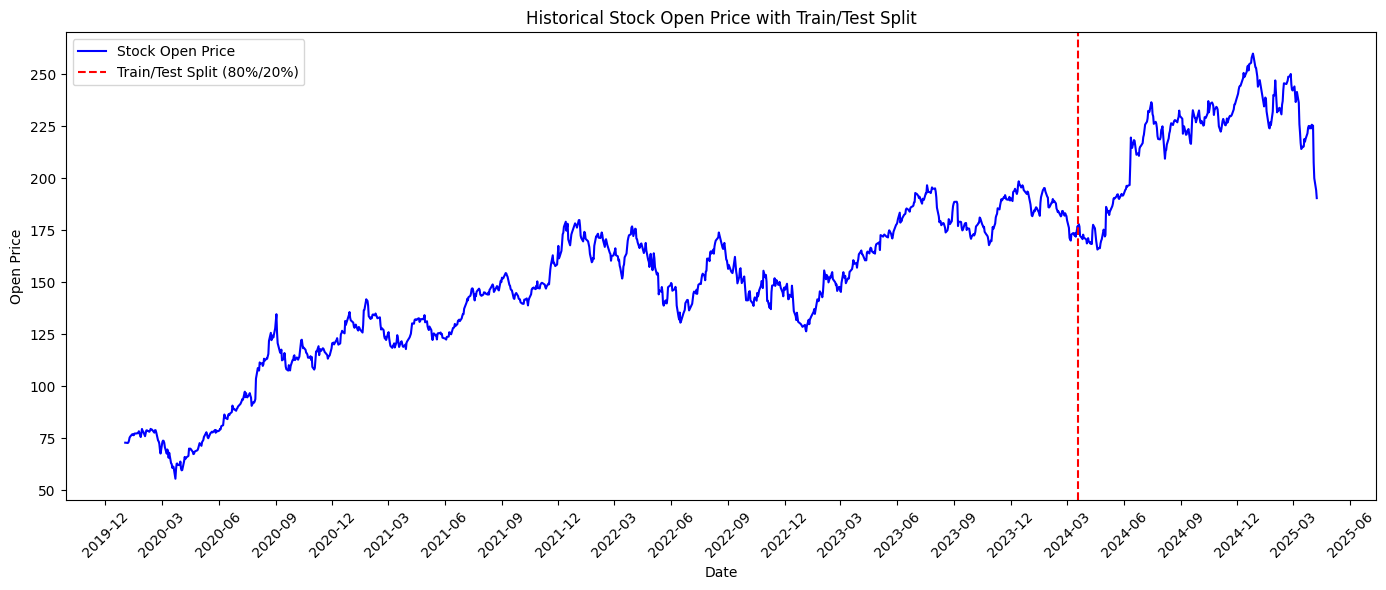

In [49]:
data['Date'] = pd.to_datetime(data['Date'])

# Split data into train and test sets (80% train, 20% test)
train_ratio = 0.8
train_size = int(len(data) * train_ratio)
train_data = data[:train_size]
test_data = data[train_size:]

print(f"Training data: {train_data.shape[0]} rows")
print(f"Test data: {test_data.shape[0]} rows")

# Visualize the stock open price data with the train/test split
plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data.iloc[:, 2], color='blue', label='Stock Open Price')
plt.axvline(x=train_data['Date'].iloc[-1], color='r', linestyle='--',
            label=f'Train/Test Split ({train_ratio*100:.0f}%/{(1-train_ratio)*100:.0f}%)')  # mark the training-test split timepoint
# Convert Date to datetime and set ticks at 3-month intervals
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Historical Stock Open Price with Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
# Extract and scale the features
# For training set
train_set = train_data.iloc[:, 2:3].values
sc = MinMaxScaler(feature_range=(0, 1))
train_set_scaled = sc.fit_transform(train_set)

# For test set (using the same scaler)
test_set = test_data.iloc[:, 2:3].values
test_set_scaled = sc.transform(test_set)

Tuning lagging days for time series forecasting.

In [52]:
# Create training data structure for hyperparameter tuning
X_train = []
y_train = []

# Enhanced hyperparameter tuning for timesteps (lagging days)
timesteps_range = [15, 30, 45, 60, 75, 90, 120]
best_mse = float('inf')
best_timesteps = 60  # initial guess
# Store results for each timestep
timesteps_results = {}

# Further split training data for validation during hyperparameter tuning
val_ratio = 0.2
val_size = int(len(train_set_scaled) * (1 - val_ratio))
train_val_data = train_set_scaled[:val_size]
validation_data = train_set_scaled[val_size:]

for timesteps in timesteps_range:
    X_temp = []
    y_temp = []
    for i in range(timesteps, len(train_val_data)):
        X_temp.append(train_val_data[i-timesteps:i, 0])
        y_temp.append(train_val_data[i, 0])

    X_validation = []
    y_validation = []
    for i in range(timesteps, len(validation_data)):
        X_validation.append(validation_data[i-timesteps:i, 0])
        y_validation.append(validation_data[i, 0])

    X_temp = np.array(X_temp)
    y_temp = np.array(y_temp)
    X_temp = np.reshape(X_temp, (X_temp.shape[0], X_temp.shape[1], 1))

    X_validation = np.array(X_validation)
    y_validation = np.array(y_validation)
    X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))

    # Use a simple model for testing
    temp_model = Sequential([
        LSTM(units=50, input_shape=(timesteps, 1)),
        Dense(units=1)
    ])
    temp_model.compile(optimizer='adam', loss='mean_squared_error')
    temp_model.fit(X_temp, y_temp, epochs=5, batch_size=32, verbose=0)

    # Evaluate on validation set
    val_mse = temp_model.evaluate(X_validation, y_validation, verbose=0)
    train_mse = temp_model.evaluate(X_temp, y_temp, verbose=0)

    timesteps_results[timesteps] = {'train_mse': train_mse, 'val_mse': val_mse}

    if val_mse < best_mse:
        best_mse = val_mse
        best_timesteps = timesteps

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


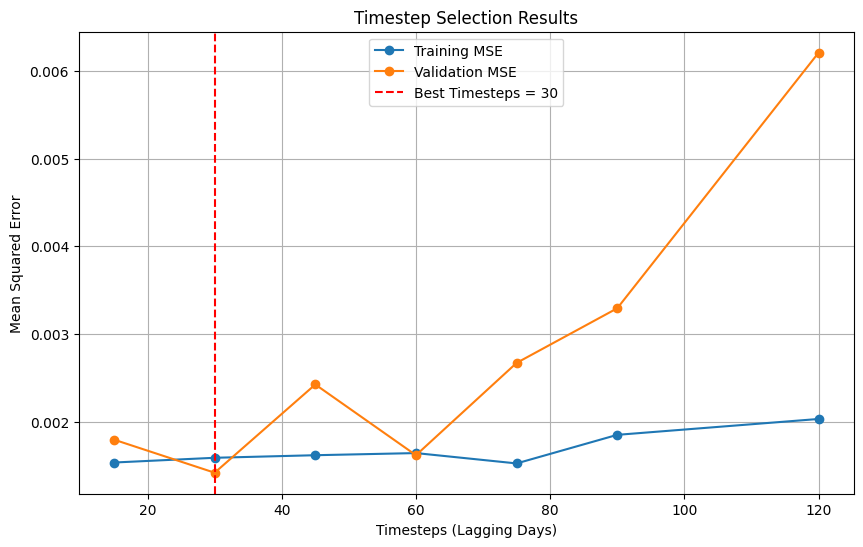

Best timesteps found: 30 with validation MSE: 0.001422


In [53]:
# Visualize the timestep selection results
plt.figure(figsize=(10, 6))
train_mse_values = [timesteps_results[t]['train_mse'] for t in timesteps_range]
val_mse_values = [timesteps_results[t]['val_mse'] for t in timesteps_range]
plt.plot(timesteps_range, train_mse_values, 'o-', label='Training MSE')
plt.plot(timesteps_range, val_mse_values, 'o-', label='Validation MSE')
plt.axvline(x=best_timesteps, color='r', linestyle='--', label=f'Best Timesteps = {best_timesteps}')
plt.xlabel('Timesteps (Lagging Days)')
plt.ylabel('Mean Squared Error')
plt.title('Timestep Selection Results')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best timesteps found: {best_timesteps} with validation MSE: {best_mse:.6f}")

## Model fitting

In [54]:
# Use the best timesteps for final training data on the full training set
X_train = []
y_train = []
for i in range(best_timesteps, len(train_set_scaled)):
    X_train.append(train_set_scaled[i-best_timesteps:i, 0])
    y_train.append(train_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# build RNN model with dynamic input shape based on best_timesteps
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(best_timesteps, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.1259
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0110
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0072
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0069
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0063
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0065
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0062
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0062
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0055
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0058
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0052
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0072
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0051
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0047
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - lo

In [74]:
# evaluate model performance
train_loss = model.evaluate(X_train, y_train, verbose=0)
print(f'Training Loss: {train_loss}')

Training Loss: 0.0007044225349090993


In [77]:
# make predictions on training data
train_predictions = model.predict(X_train)
train_predictions = sc.inverse_transform(train_predictions)
actual_prices = sc.inverse_transform([y_train])

# calculate metrics
mse = mean_squared_error(actual_prices[0], train_predictions[:,0])
r2 = r2_score(actual_prices[0], train_predictions[:,0])
print(f'MSE: {mse:.2f}')
print(f'R2 Score: {r2:.2f}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
MSE: 14.40
R2 Score: 0.99


Evaluation on the test set.

In [72]:
# Prepare test data sequence
X_test = []
y_test = []

# Create a single continuous sequence for prediction by combining train and test data
combined_data = np.vstack((train_set_scaled, test_set_scaled))

# Generate sequences that span the boundary between train and test sets
for i in range(len(train_set_scaled) - best_timesteps, len(combined_data) - best_timesteps):
    X_test.append(combined_data[i:i+best_timesteps, 0])
    y_test.append(combined_data[i+best_timesteps, 0])

X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# make predictions on test data
test_predictions = model.predict(X_test)
test_predictions = sc.inverse_transform(test_predictions)

# The actual test prices correspond to our predictions, but shifted by the timesteps
# We need to align the predictions with the original test data
actual_test_prices = test_set[:len(test_predictions)]

# calculate test metrics (only if shapes match)
if len(actual_test_prices) == len(test_predictions):
    test_mse = mean_squared_error(actual_test_prices, test_predictions)
    test_r2 = r2_score(actual_test_prices, test_predictions)
    print(f'Test MSE: {test_mse:.2f}')
    print(f'Test R2 Score: {test_r2:.2f}')
else:
    print(f'Shape mismatch: actual_test_prices {actual_test_prices.shape}, test_predictions {test_predictions.shape}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test MSE: 68.48
Test R2 Score: 0.88


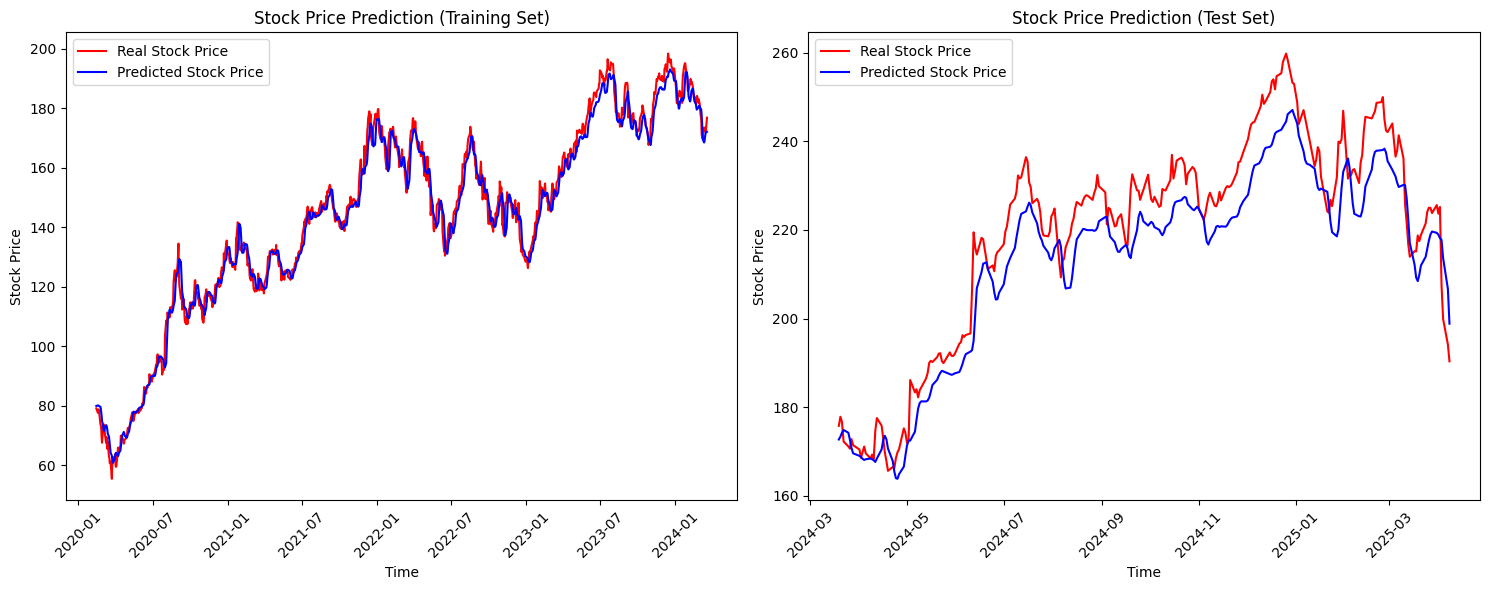

In [73]:
# plotting predictions
plt.figure(figsize=(15,6))

# Plot training predictions
plt.subplot(1, 2, 1)
plt.plot(train_data.iloc[best_timesteps:]['Date'], actual_prices[0], color='red', label='Real Stock Price')
plt.plot(train_data.iloc[best_timesteps:]['Date'], train_predictions[:,0], color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction (Training Set)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)

# Plot test predictions
plt.subplot(1, 2, 2)
# Create date indices for predictions that align with the test set
test_dates = test_data['Date'][:len(test_predictions)]
plt.plot(test_data['Date'][:len(actual_test_prices)], actual_test_prices, color='red', label='Real Stock Price')
plt.plot(test_dates, test_predictions, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction (Test Set)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Trend Adjustment

In [78]:
# Apply trend adjustment to fix edge problem
# Calculate average error to see if predictions are systematically off
error = actual_prices[0] - train_predictions[:,0]
mean_error = np.mean(error)
print(f"Mean prediction error: {mean_error:.4f}")

# Apply bias correction to training predictions
train_predictions_adjusted = train_predictions + mean_error

Mean prediction error: 1.0687


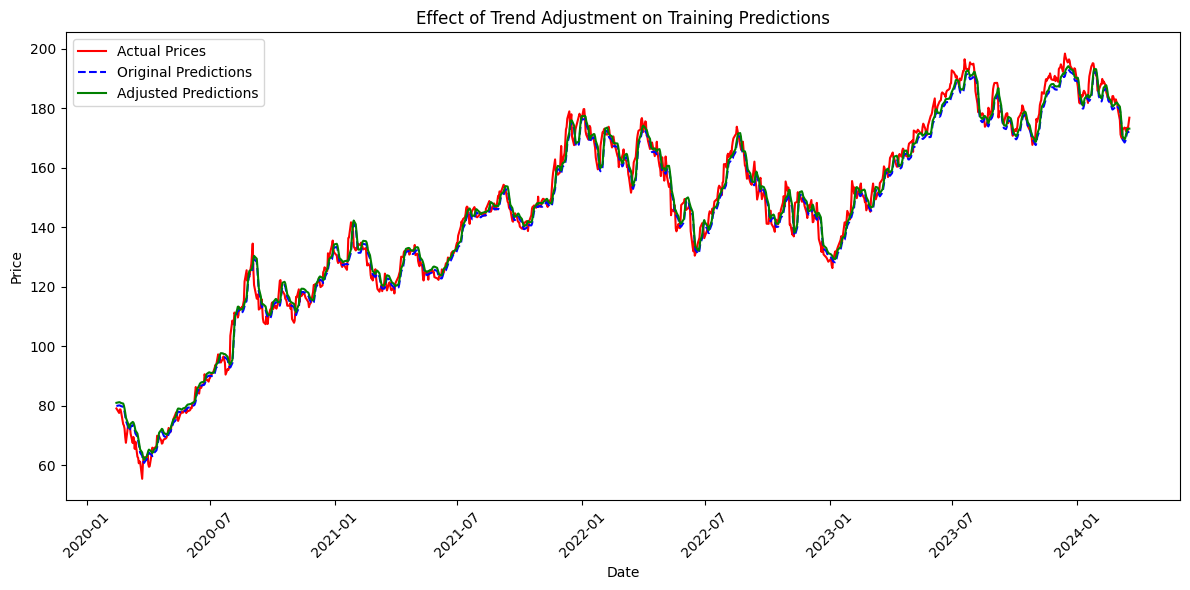

In [79]:
# Visualize the effect of adjustment
plt.figure(figsize=(12, 6))
plt.plot(train_data.iloc[best_timesteps:]['Date'], actual_prices[0], 'r-', label='Actual Prices')
plt.plot(train_data.iloc[best_timesteps:]['Date'], train_predictions[:,0], 'b--', label='Original Predictions')
plt.plot(train_data.iloc[best_timesteps:]['Date'], train_predictions_adjusted[:,0], 'g-', label='Adjusted Predictions')
plt.title('Effect of Trend Adjustment on Training Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [81]:
# Create a single continuous sequence for prediction by combining train and test data
combined_data = np.vstack((train_set_scaled, test_set_scaled))

# Generate sequences that span the boundary between train and test sets
X_test = [combined_data[i:i+best_timesteps, 0] for i in range(len(train_set_scaled) - best_timesteps, len(combined_data) - best_timesteps)]
y_test = [combined_data[i+best_timesteps, 0] for i in range(len(train_set_scaled) - best_timesteps, len(combined_data) - best_timesteps)]

X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# make predictions on test data
test_predictions = model.predict(X_test)
test_predictions = sc.inverse_transform(test_predictions)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [82]:
# Apply the same adjustment to test predictions
test_predictions_adjusted = test_predictions + mean_error


# The actual test prices correspond to our predictions, but shifted by the timesteps
# We need to align the predictions with the original test data
actual_test_prices = test_set[:len(test_predictions)]

# calculate test metrics (only if shapes match)
if len(actual_test_prices) == len(test_predictions):
    test_mse = mean_squared_error(actual_test_prices, test_predictions)
    test_r2 = r2_score(actual_test_prices, test_predictions)
    adjusted_test_mse = mean_squared_error(actual_test_prices, test_predictions_adjusted)
    adjusted_test_r2 = r2_score(actual_test_prices, test_predictions_adjusted)

    print(f'Test MSE: {test_mse:.2f}, R2 Score: {test_r2:.2f}')
    print(f'Adjusted Test MSE: {adjusted_test_mse:.2f}, R2 Score: {adjusted_test_r2:.2f}')
else:
    print(f'Shape mismatch: actual_test_prices {actual_test_prices.shape}, test_predictions {test_predictions.shape}')

Test MSE: 68.48, R2 Score: 0.88
Adjusted Test MSE: 55.94, R2 Score: 0.90


In [86]:
best_timesteps

30

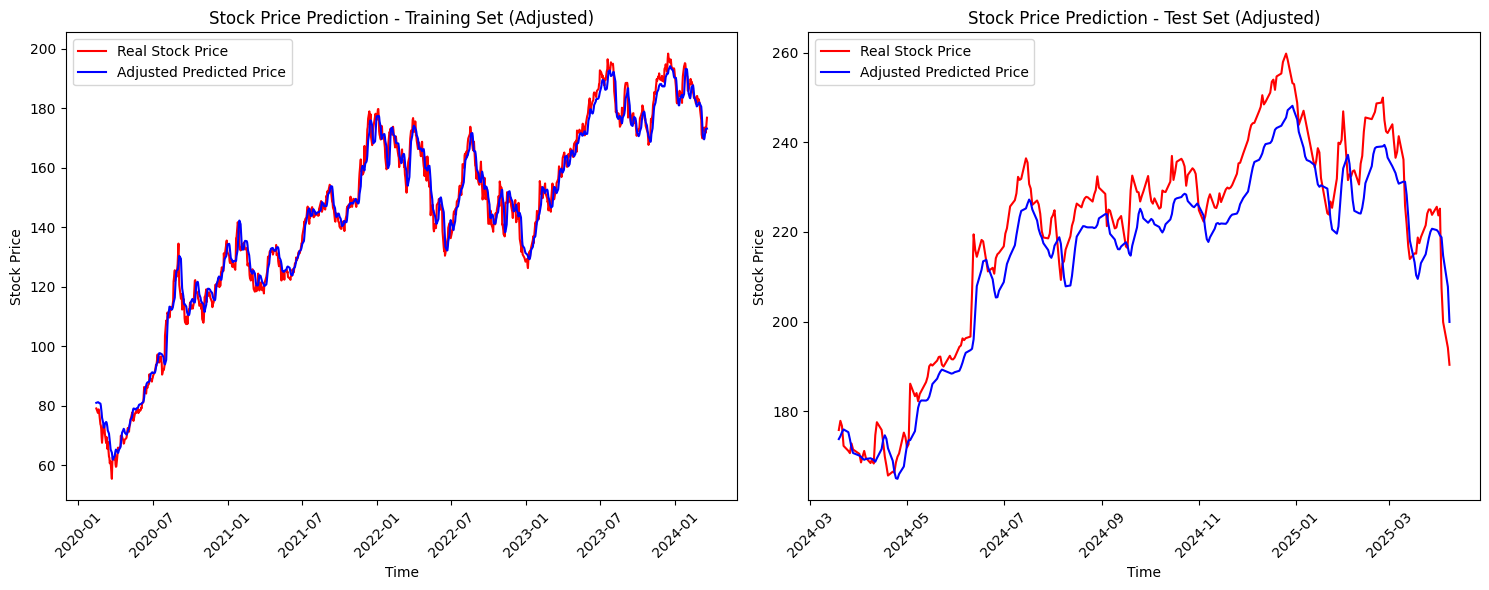

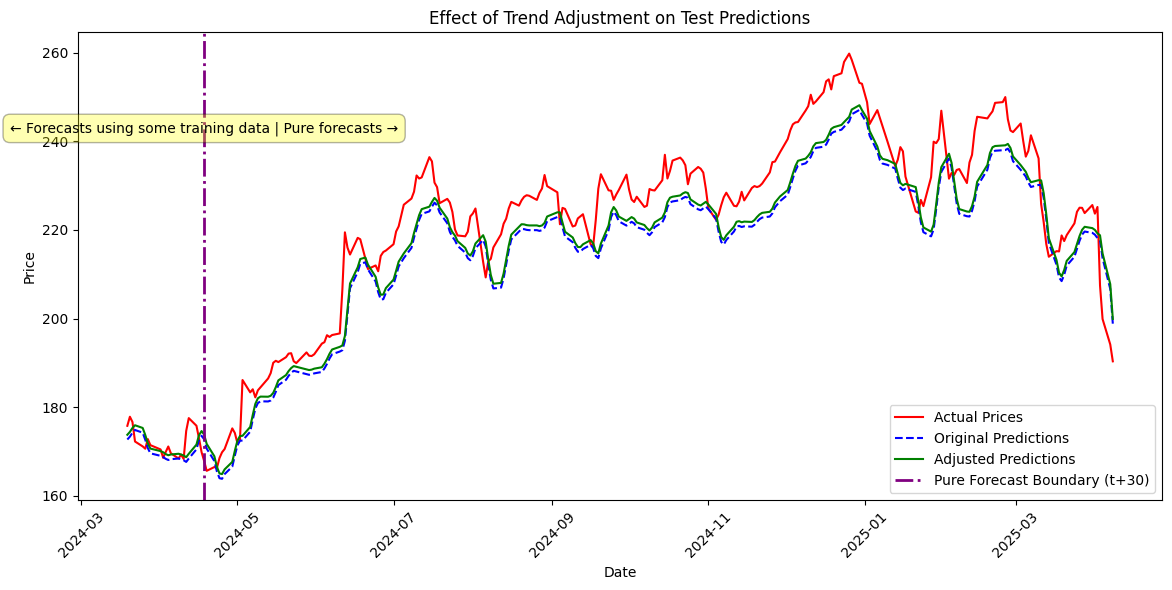

In [87]:
# plotting final predictions with adjustments
plt.figure(figsize=(15,6))

# Plot training predictions
plt.subplot(1, 2, 1)
plt.plot(train_data.iloc[best_timesteps:]['Date'], actual_prices[0], color='red', label='Real Stock Price')
plt.plot(train_data.iloc[best_timesteps:]['Date'], train_predictions_adjusted[:,0], color='blue', label='Adjusted Predicted Price')
plt.title('Stock Price Prediction - Training Set (Adjusted)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)

# Plot test predictions
plt.subplot(1, 2, 2)
test_dates = test_data['Date'][:len(test_predictions)]
plt.plot(test_data['Date'][:len(actual_test_prices)], actual_test_prices, color='red', label='Real Stock Price')
plt.plot(test_dates, test_predictions_adjusted, color='blue', label='Adjusted Predicted Price')
plt.title('Stock Price Prediction - Test Set (Adjusted)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Compare original vs adjusted predictions in the test set
plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_test_prices, 'r-', label='Actual Prices')
plt.plot(test_dates, test_predictions, 'b--', label='Original Predictions')
plt.plot(test_dates, test_predictions_adjusted, 'g-', label='Adjusted Predictions')

# Mark the point after which no training data is used in forecasting
if best_timesteps < len(test_dates):
    forecast_boundary_date = test_dates.iloc[0] + pd.Timedelta(days=best_timesteps)
    plt.axvline(x=forecast_boundary_date, color='purple', linestyle='-.', linewidth=2,
                label=f'Pure Forecast Boundary (t+{best_timesteps})')

    # Add text annotation explaining the boundary
    plt.annotate('← Forecasts using some training data | Pure forecasts →',
                 xy=(forecast_boundary_date, plt.ylim()[1]*0.9),
                 xytext=(0, 10), textcoords='offset points',
                 ha='center', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3),
                 rotation=0, fontsize=10)

plt.title('Effect of Trend Adjustment on Test Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()